# Fidelity

In [36]:
from qutip import *
from scipy import signal
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool
import h5py

##--- Energy per spin for interaction range order---------
def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta

##-- Drive-------------------------------------------------

def drive1(t, args):
    w = args['omega']
    T = 2 * np.pi/w

    sqr1 = signal.square(2 * np.pi/T * t)
    if sqr1 == -1:
        sqr1= 0
    return sqr1

def drive2(t, args):
    w = args['omega']
    T = 2 * np.pi/w

    sqr1 = -signal.square(2 * np.pi/T * t)
    if sqr1 == -1:
        sqr1= 0
    return sqr1

def drive3(t, args):    # square cos wave transverse
    w = args['omega']
    h0 = args['h0']
    h = args['h']
    T = 2 * np.pi/w

    sint = -np.sin(w*t)
    if sint<=0:
        sint = 0
    sqrsin = h0 + h * sint
    return sqrsin

def get_hamiltonian(N,N1, lambd_x, lambd_y, Jvalue, beta, g, ea, eb):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)
    H10, H11, H12, H21, H22, H23, H24 =  empt, empt, empt, empt, empt, empt, empt
    
    ##-- Hamiltonian ------------------------------------------- 
    ##-- First half

    for i in range(N1):  
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H11 = H11 + Qobj(tensor(id,tensor(sx,id1)).full()) * g * (1-ea)

    for i in range(N1,N):  
        id = qeye(2**i)    
        dim12 = N-1-i
        id1 = qeye(2**dim12)
        H12 = H12 + Qobj(tensor(id,tensor(sx,id1)).full()) * g * (1-eb)   

    ##-- Second half

    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H21 = H21 + Qobj(tensor(id, tensor(sy, tensor(id1, tensor(sy,id2)))).full()) * j_ij(Jvalue, i,j, beta)
        
    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H22 = H22 + Qobj(tensor(id,tensor(sz,id1)).full()) 

    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H23 = H23 + Qobj(tensor(id,tensor(sx,id1)).full()) * lambd_x

    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H24 = H24 + Qobj(tensor(id,tensor(sy,id1)).full()) * lambd_y
    
    return H11, H12, H21, H22, H23, H24

##-- Dynamics
def run_dynm_fidelity(args):
    N,N1,lambd_x,lambd_y,Jvalue=args['N'],args['N1'],args['lambd_x'],args['lambd_y'],args['Jvalue']
    beta,g,ea,eb,w = args['beta'],args['g'],args['ea'],args['eb'],args['omega']
    h0,h,times,sz_o,opts = args['h0'],args['h'],args['times'], args['sz_o'], args['opts']
    
    H11, H12, H21, H22, H23, H24 =  get_hamiltonian(N,N1, lambd_x, lambd_y, Jvalue, beta, g, ea, eb)
    
    params = args
    
    H = [[H11,drive1], [H12,drive1],[H21,drive2], [H22,drive3], [H23,drive2], [H24,drive2]]
    grket = basis(2**N,0)        
    out = mesolve(H, grket, times, [], [], args = params)
    return out.states[-1]

print("Function definition complete!!")

Function definition complete!!


In [41]:
%%time
from qutip import *
import numpy as np
from scipy import signal
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool
from tqdm import tqdm
import h5py


Ns = [4,6,8,10]

omega = 20.0
w = omega
T = 2 * np.pi/w
sample_rate = 10
time_periods = 2000
times = np.linspace(0,T * time_periods, sample_rate * time_periods+1)

ea, eb = 0.03, 0.9
g = np.pi/T
Jvalues = [0.072/T, 0.2/T]   

freezing_pts = jn_zeros(0, 5)
hpt = freezing_pts[2]

lamb = 0.0
lambd_x = lamb
lambd_y = lamb

sx,sy,sz = sigmax(), sigmay(), sigmaz()   
h = hpt * w/4
datap = np.zeros((N, len(times)))
            
# Define a single spin Hamiltonian
position = 7

id = qeye(2**position)
dim12 = N-1-position
id1 = qeye(2**dim12)
sz_0 = Qobj(tensor(id,tensor(sz,id1)).full())

'''
position = 7
id = qeye(2**pos_0)
dim12 = N-1-pos_0
id1 = qeye(2**dim12)
sz_7 = Qobj(tensor(id,tensor(sz,id1)).full())
'''

nprocs = 8
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5)

deltas = np.linspace(-0.5, 0.5, 24)
betas = [0.0, 1.5, 2.5, float('inf')]
beta = 0

twoTtimes = np.linspace(0, T * time_periods, int(time_periods/2)+1)
idx = np.searchsorted(times, twoTtimes)

for N in Ns: 
    N1= int(N/2)
    N2= N-N1
    
    params1 = [{'h0':0, 'h':w/4 * (hpt +delt), 'omega':omega, 'N':N,'N1':N1,\
                'opts':opts,'sz_o':sz_0, 'lambd_x':lambd_x,\
                'lambd_y':lambd_y, 'Jvalue':Jvalues[0],'beta':beta,\
                'g':g,'ea':ea,'eb':eb, 'times':times} for delt in deltas]
    
    params2 = [{'h0':0, 'h':w/4 * (hpt +delt), 'omega':omega, 'N':N,'N1':N1,\
                'opts':opts,'sz_o':sz_0, 'lambd_x':lambd_x,\
                'lambd_y':lambd_y, 'Jvalue':Jvalues[1],'beta':beta,\
                'g':g,'ea':ea,'eb':eb, 'times':times} for delt in deltas]

    params = params1 + params2
    data = p.map(run_dynm_fidelity,tqdm(params))

    init_state = basis(2**N,0)      
    fidel = np.array([fidelity(init_state,data[i]) for i in range(2*len(deltas))])

    fname = "fidelity_N"+str(N)+"_i" + str(position) + "_beta_" + str(beta) +"_.hdf5"
    with h5py.File(fname, 'w') as hf:
        hf.create_dataset('fidelilty', np.shape(fidel), data=fidel)
        hf.create_dataset('times', np.shape(times), data=times)
        hf.create_dataset('deltas', np.shape(deltas), data=deltas)
        hf.attrs['N'] = N         
        hf.attrs['w'] = w
        hf.attrs['time_periods'] = time_periods
        hf.attrs['position'] = position
        hf.attrs['Jvalues'] = Jvalues
        hf.attrs['beta'] = beta 

100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [1:00:25<00:00, 75.53s/it]


CPU times: user 56.4 s, sys: 2.49 s, total: 58.9 s
Wall time: 2h 49min 13s


In [42]:
!ls fidelity_N*>fidelity.txt

In [23]:
!cat fidelity.txt

fidelity_N10_i7_beta_0_.hdf5
fidelity_N8_i7_beta_0_.hdf5
fidelity_N6_i7_beta_0_.hdf5


fidelity_N6_i7_beta_0_.hdf5
fidelity_N8_i7_beta_0_.hdf5
fidelity_N10_i7_beta_0_.hdf5


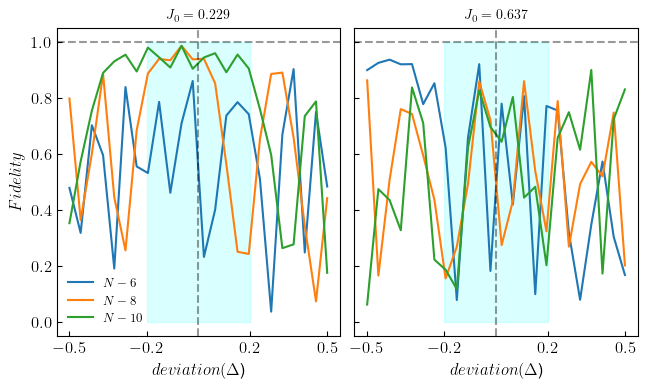

In [13]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({"figure.figsize": (7.5,4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 12,"font.sans-serif": ["Helvetica"]})


fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.0, wspace=0.05)


with open("fidelity.txt", 'r') as fp:
    lines = fp.readlines()
    x = len(lines)
    for i in range(0,x):
        filename = lines[i][:-1]
        print(filename)
        
        with h5py.File(filename, "r") as f:
            fidel = f['fidelilty'][()]
            times = f['times'][()]        
            deltas = f['deltas'][()]        
            Jvalues = f.attrs['Jvalues']
            beta = f.attrs['beta']
            w = f.attrs['w']
            N = f.attrs['N']
            time_periods = f.attrs['time_periods']
            position = f.attrs['position']

            fidels = fidel.reshape((2, len(deltas)))
            for i in range(2):
                axs[i].plot(deltas, fidels[i].real, label = fr"$N-{N}$")

for i in range(2):
    axs[i].set_xlabel(r'$deviation(\Delta$)')
    axs[i].tick_params(which='both', axis="both", direction="in")
    axs[i].set_title(fr"$J_0 ={Jvalues[i]:1.3f}$", fontsize = 10)
    axs[i].set_xticks([-.5,-.2,0.2,.5])
    
    axs[i].axhline(y=1.0, linestyle = '--', color= 'black', alpha = 0.4)
    axs[i].axvline(x=0, linestyle = '--', color= 'black', alpha = 0.4)

    axs[i].fill_betweenx(y=[0, 1], x1=-0.2, x2=0.2, color='aqua', alpha=0.15)

axs[0].set_ylabel(fr'$Fidelity$')
axs[0].legend(frameon = False, loc =3, fontsize = 9)
plt.savefig('fidelity.pdf')
plt.show()

### interpolation data

fidelity_N10_i7_beta_0_.hdf5
fidelity_N8_i7_beta_0_.hdf5
fidelity_N6_i7_beta_0_.hdf5


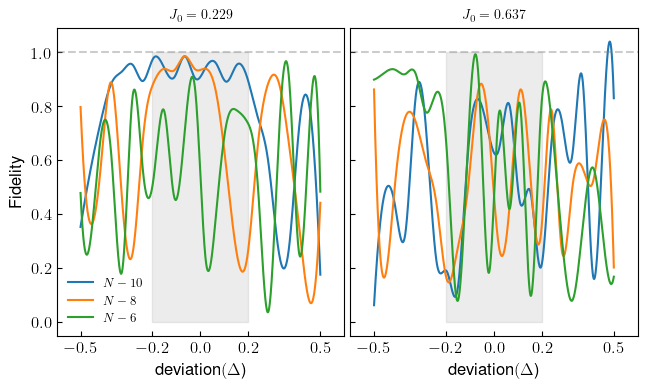

In [58]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate 

plt.rcParams.update({"figure.figsize": (7.5,4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 12,"font.sans-serif": ["Helvetica"]})


fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.0, wspace=0.02)


with open("fidelity.txt", 'r') as fp:
    lines = fp.readlines()
    x = len(lines)
    for i in range(0,x):
        filename = lines[i][:-1]
        print(filename)
        
        with h5py.File(filename, "r") as f:
            fidel = f['fidelilty'][()]
            times = f['times'][()]        
            deltas = f['deltas'][()]        
            Jvalues = f.attrs['Jvalues']
            beta = f.attrs['beta']
            w = f.attrs['w']
            N = f.attrs['N']
            time_periods = f.attrs['time_periods']
            position = f.attrs['position']

            fidels = fidel.reshape((2, len(deltas)))
            for i in range(2):
                x = deltas
                y = fidels[i].real
                
                temp = interpolate.splrep(x, y, s=0) 
                xnew = np.linspace(-.5,.5, 1000)
                ynew = interpolate.splev(xnew, temp, der=0) 

                axs[i].plot(xnew, ynew, label = fr"$N-{N}$")   

for i in range(2):
    axs[i].set_xlabel(r'deviation$(\Delta$)')
    axs[i].tick_params(which='both', axis="both", direction="in")
    axs[i].set_title(fr"$J_0 ={Jvalues[i]:1.3f}$", fontsize = 10)
    axs[i].set_xticks([-.5,-.2,0,0.2,.5])
    axs[i].set_xlim(-.6,.6)
    
    axs[i].axhline(y=1.0, linestyle = '--', color= 'gray', alpha = 0.4)
    #axs[i].axvline(x=0, linestyle = '--', color= 'black', alpha = 0.4)

    axs[i].fill_betweenx(y=[0, 1], x1=-0.2, x2=0.2, color='gray', alpha=0.15)

axs[0].set_ylabel(r'Fidelity')
axs[0].legend(frameon = False, loc =3, fontsize = 9)

plt.savefig('fidelity.pdf')
plt.show()